In [1]:
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import dataset
import learning

## 神经网络的梯度

In [3]:
x = np.array([2.0, 3.0, 4.0])
x

array([2., 3., 4.])

In [4]:
w = np.array([
    [1.0, 2.0],
    [1.0, 2.0],
    [1.0, 2.0],
])
w

array([[1., 2.],
       [1., 2.],
       [1., 2.]])

In [5]:
w.shape

(3, 2)

In [6]:
np.dot(x, w)

array([ 9., 18.])

In [7]:
class SimpleLayer(object):

    def __init__(self, input: int, output: int) -> None:
        self.w = np.random.randn(input, output)  # 高斯分布的权重

    def forward(self, x):
        return np.dot(x, self.w)
    
    def loss(self, x, t):
        z = self.forward(x)
        y = learning.softmax(z)
        loss = learning.cross_entropy_error(y, t)
        return loss


In [8]:
net = SimpleLayer(2, 3)
net

In [9]:
t = np.array([1])
x = np.array([8.0, 9.0])
x, t

(array([8., 9.]), array([1]))

In [10]:
net.forward(x)

array([-1.12012559, -3.76626048, -4.88414689])

In [11]:
net.loss(x, t)

2.7360792624936274

In [12]:
def gradient(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)  # 生成和x形状相同的数组

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index

        tmp_val = x[idx]

        # f(x+h)的计算
        x[idx] = tmp_val + h
        fxh1 = f(x)

        # f(x-h)的计算
        x[idx] = tmp_val - h
        fxh2 = f(x)
        grad[idx] = (fxh1 - fxh2) / (2 * h)

        x[idx] = tmp_val  # 还原值
        it.iternext()

    return grad


In [13]:
dw = gradient(lambda w: net.loss(x, t), net.w)
dw

array([[ 7.31183355, -7.48139716,  0.16956361],
       [ 8.22581273, -8.41657179,  0.19075907]])

## 学习算法的实现

### 随机梯度下降

In [14]:
class TwoLayer(object):

    def __init__(self, input, hidden, output) -> None:
        self.w1 = np.random.randn(input, hidden)
        self.b1 = np.zeros(hidden)
        self.w2 = np.random.randn(hidden, output)
        self.b2 = np.zeros(output)

    def forward(self, x):
        a1 = np.dot(x, self.w1) + self.b1
        z1 = learning.sigmoid(a1)
        a2 = np.dot(z1, self.w2) + self.b2
        return learning.softmax(a2)

    def loss(self, x, t):
        y = self.forward(x)
        return learning.cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.forward(x)
        y = np.argmax(y, axis=1)

        if t.ndim == 2:
            t = np.argmax(t, axis=1)

        return np.sum(y == t) / float(x.shape[0])

    def gradient(self, x, t):

        def lossw(w): return self.loss(x, t)

        self.grad_w1 = gradient(lossw, self.w1)
        self.grad_b1 = gradient(lossw, self.b1)
        self.grad_w2 = gradient(lossw, self.w2)
        self.grad_b2 = gradient(lossw, self.b2)


In [15]:
net = TwoLayer(2, 4, 1)
net

In [16]:
x = np.array([0.0, 0.0])
t = np.array([0])
x, t

(array([0., 0.]), array([0]))

In [17]:
net.gradient(x, t)

In [18]:
y = net.forward(x)
y

array([1.])

## 训练一个异或

In [19]:
x_train = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0],
])
x_train

array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]])

In [20]:
t_train = np.array([
    0,
    1,
    1,
    0
])
t_train

array([0, 1, 1, 0])

In [21]:
net = TwoLayer(2, 30, 2)

In [22]:
from tqdm import tqdm

In [23]:
epoch = 1000
lr = 0.1

x_batch = x_train
t_batch = t_train

loss_list = []

bar = tqdm(range(epoch))

for e in bar:

    net.gradient(x_batch, t_batch)

    for key in ('w1', 'b1', 'w2', 'b2'):
        attr = getattr(net, key)
        grad = getattr(net, f'grad_{key}')
        attr -= lr * grad

    loss = net.loss(x_batch, t_batch)
    loss_list.append(loss)

    lr = loss * 0.5 * (epoch - e) / epoch

    acc = net.accuracy(x_batch, t_batch) * 100

    bar.set_postfix(dict(acc=f'{acc:.2f}%', loss=f'{loss:.3f}', lr=f'{lr:.3f}'))

100%|██████████| 1000/1000 [00:19<00:00, 50.50it/s, acc=100.00%, loss=1.399, lr=0.001]


In [24]:
for x in x_train:
    y = net.forward(x)
    print(x, y, np.argmax(y))

[0. 0.] [0.99093773 0.00906227] 0
[0. 1.] [0.01115737 0.98884263] 1
[1. 0.] [0.01229811 0.98770189] 1
[1. 1.] [0.98334784 0.01665216] 0


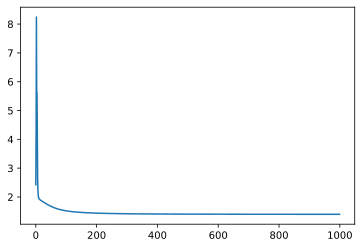

In [25]:
axes = plt.figure().add_subplot()
axes.plot(loss_list)
plt.show()

## MNIST 手写数字识别

In [26]:
x_train, x_test, t_train, t_test = dataset.load_mnist()

In [27]:
net = TwoLayer(784, 13, 10)

In [28]:
np.seterr(all="ignore")

loss_list = []

epoch = 100
lr = 0.1
batch_size = 5  # 数量大的话太慢了，我这破机器
train_size = 5

for e in range(epoch):

    bar = tqdm(range(train_size // batch_size))
    bar.set_description(f"Epoch {e}")

    indices = list(range(train_size))
    total = 0
    right = 0

    for _ in bar:

        batch_mask = np.random.choice(indices, batch_size, replace=False)
        for var in batch_mask:
            indices.remove(var)

        x = x_train[batch_mask]
        t = t_train[batch_mask]

        net.gradient(x, t)

        for key in ('w1', 'b1', 'w2', 'b2'):
            attr = getattr(net, key)
            grad = getattr(net, f'grad_{key}')
            attr -= lr * grad

        y = net.forward(x)
        r = np.argmax(y, axis=1)

        total += x.shape[0]
        right += np.sum(r == t)

        loss = learning.cross_entropy_error(y, t)
        loss_list.append(loss)

        lr = loss * 0.1 * (epoch - e) / epoch
        lr = lr if lr < 0.5 else 0.5

        acc = right / total * 100

        bar.set_postfix(dict(acc=f'{acc:.2f}%', loss=f'{loss:.3f}', lr=f'{lr:.3f}'))


Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it, acc=100.00%, loss=1.967, lr=0.002]


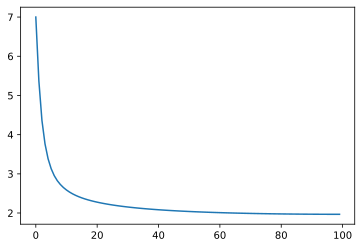

In [29]:
axes = plt.figure().add_subplot()
axes.plot(loss_list)
plt.show()

In [30]:
net.accuracy(x, t)

1.0

In [31]:
y = net.forward(x[0])
np.argmax(y)

0

In [32]:
y = net.forward(x_test[0])
np.argmax(y), t_test[0]

(9, 3)